In [1]:
#import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
#hs_2028_geo = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\GIS_files\\pu_with_proj_SPLIT.geojson').to_crs(epsg=3857)

#hs_full_geo contains the count, base and student gen for all planning units
hs_full_geo = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\GIS_files\\hs_full_geo.geojson').to_crs(epsg=3857)
hs_full_geo.head(2)

,pu_2324_84,X,Y,Region,Shape_Area,count,basez,student_gen,geometry
0,1,2.049028e+06,893128.606346,North,3.556198e+07,6.0,6.0,0,"POLYGON ((-8.77e+06 4.33e+06, -8.77e+06 4.33e+..."
1,2,2.039923e+06,835434.121317,North,2.080136e+07,18.0,8.0,0,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+..."


In [3]:
dps_base = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\dps_base_2324.geojson')
dps_base = dps_base.to_crs(epsg = 3857)
base_hs = {'Jordan High School','Riverside High School','Northern High School','Hillside High School','Southern High School'}
dps_base_hs = dps_base[dps_base['name'].isin(base_hs)]
dps_base_hs = dps_base_hs[['name','geometry']]
dps_base_hs.loc[5,'name']='New High School'
dps_base_hs = dps_base_hs.reset_index()

#df of current base high schools and their geographies

In [4]:
dps_pu = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\GIS_Files\\pu_2324_SPLIT.geojson').rename(columns={'pu_2324_848':'pu_2324_84'})
dps_pu = dps_pu.to_crs(epsg = 3857).sort_values(by='pu_2324_84')
dps_pu.head(2)

#df of all planning units

,OBJECTID,pu_2324_84,X,Y,M_min,PS_ID,PUID2122_2,ps_id_833,psid_982,TIMS_PU,Region,Shape_Length,Shape_Area,geometry
0,1,1,2.049028e+06,893128.606346,0.0,589,589,1,1,PU589,North,26532.120021,3.556198e+07,"POLYGON ((-8.77e+06 4.33e+06, -8.77e+06 4.33e+..."
1,2,2,2.039923e+06,835434.121317,0.0,401,401,2,2,PU401,North,19333.085511,2.080136e+07,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+..."


In [8]:
#precomputed stuff for function
school_names = ['Southern High School','Hillside High School','Northern High School','Riverside High School','Jordan High School','New High School']
capacities = [1340,1335,1400,1240,1510,1550]

In [9]:
#local copies of dfs
local_hs_full_geo = hs_full_geo.copy()
local_dps_base_hs = dps_base_hs.copy()

In [31]:
#boundary siting and scoring algorithm
def score_candidate(candidate,weight):
    k=0.15
    capacity_penalty = 0
    total_capacity = hs_full_geo['basez'].sum()
    counts = pd.DataFrame({'school':school_names,
                           'capacity':capacities,
                           'count':[0,0,0,0,0,0],
                           'adjust':[0,0,0,0,0,0]
                            })                              

    
    candidate_geom = candidate['geometry']
    local_dps_base_hs.loc[5,'geometry']=candidate_geom.centroid
    
    
    for i in range(30):                                    
        assignments = []
        for pu in local_hs_full_geo.itertuples(index=False):                   
            centroid = pu.geometry.centroid
            pu_scores = []
            for j in range(6):    
                dist = centroid.distance(local_dps_base_hs.loc[j,'geometry'])
                score = dist + counts.loc[j,'adjust']
                pu_scores.append(score)
            assign = school_names[pu_scores.index(min(pu_scores))]
            assignments.append(assign)
        local_hs_full_geo['assign'] = assignments
    
        for j,school in enumerate(school_names):
            assigned_students = int(local_hs_full_geo.loc[local_hs_full_geo['assign'] == school, 'basez'].sum() + local_hs_full_geo.loc[local_hs_full_geo['assign'] == school, 'student_gen'].sum()*k)
            counts.loc[j, 'count'] = assigned_students  
                
            if counts.loc[j,'count'] <= counts.loc[j,'capacity']*0.80:
                counts.loc[j,'adjust'] -= weight * (30-i)
            elif counts.loc[j,'count'] - counts.loc[j,'capacity'] >= 0:
                counts.loc[j,'adjust'] += weight * (30-i)
            else:
                pass

    objective=local_hs_full_geo.merge(local_dps_base_hs,left_on='assign',right_on='name',how='left')
    objective['distance']=objective['geometry_x'].distance(objective['geometry_y'])
    objective_score = ((objective['basez']+k*objective['student_gen'])*objective['distance']).sum()/(10**7)

    #punish objective score if still over cap
    for j in range(6):
        if counts.loc[j,'count'] < 0.80 * counts.loc[j,'capacity']:
            capacity_penalty += 0.5
        elif counts.loc[j,'count'] > counts.loc[j,'capacity']:
            capacity_penalty += 0.5

    objective_score += capacity_penalty
    counts['pct'] = counts['count']/counts['capacity']

    return objective_score,counts

In [32]:
candidate = dps_pu.loc[40]
score_candidate(candidate,5)

(5.169411157799695,
                   school  capacity  count  adjust       pct
 0   Southern High School      1340   1662    2325  1.240299
 1   Hillside High School      1335   1421    2325  1.064419
 2   Northern High School      1400   1383    1990  0.987857
 3  Riverside High School      1240   1298     900  1.046774
 4     Jordan High School      1510   1272   -1170  0.842384
 5        New High School      1550    860   -2325  0.554839)

<Axes: title={'center': 'Expanded HS Boundaries'}>

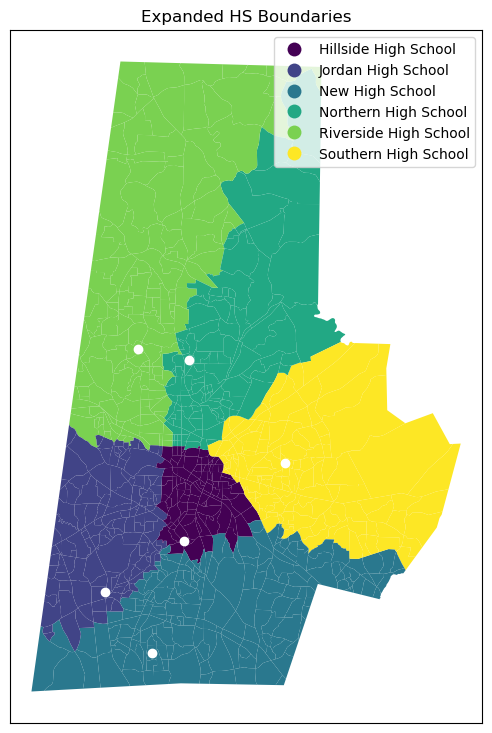

In [29]:
#plot assigned boundaries

fig,ax = plt.subplots(figsize = (7,9))

local_hs_full_geo.plot(
    column='assign',
    ax = ax,
    cmap = 'viridis',
    legend = True
)

ax.set_xticks([])
ax.set_yticks([])

plt.title('Expanded HS Boundaries')
local_dps_base_hs.plot(ax=plt.gca(), color = 'white')

In [10]:
#bayesian optimization with optuna
!pip install optuna

In [11]:
import optuna

In [12]:
def objective_param(trial):
    weight = trial.suggest_int('weight',10,50)

    score = score_candidate(candidate,weight,n_trials)
    return score

In [13]:
n_trials = 30

In [14]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_param,n_trials = 30)
print('Best Parameters:',study.best_params)
print('Best Value:',study.best_value)

[I 2025-07-14 13:57:54,583] A new study created in memory with name: no-name-092d5e9d-c79f-4cb7-98d0-2ec090ebcab7
[I 2025-07-14 13:58:20,776] Trial 0 finished with value: 4.081499520929285 and parameters: {'weight': 16}. Best is trial 0 with value: 4.081499520929285.
[I 2025-07-14 13:58:47,069] Trial 1 finished with value: 5.996049187468369 and parameters: {'weight': 12}. Best is trial 0 with value: 4.081499520929285.
[I 2025-07-14 13:59:12,917] Trial 2 finished with value: 4.0907356629740566 and parameters: {'weight': 15}. Best is trial 0 with value: 4.081499520929285.
[I 2025-07-14 13:59:39,241] Trial 3 finished with value: 5.639928572561893 and parameters: {'weight': 14}. Best is trial 0 with value: 4.081499520929285.
[I 2025-07-14 14:00:05,068] Trial 4 finished with value: 4.786001964739275 and parameters: {'weight': 45}. Best is trial 0 with value: 4.081499520929285.
[I 2025-07-14 14:00:30,981] Trial 5 finished with value: 5.906476299680033 and parameters: {'weight': 11}. Best is 

Best Parameters: {'weight': 16}
Best Value: 4.081499520929285


In [17]:
score_candidate(candidate,16)

(4.081499520929285,
                   school  capacity  count  adjust
 0   Southern High School      1340   1255    2752
 1   Hillside High School      1335   1326    6512
 2   Northern High School      1400   1309    1856
 3  Riverside High School      1240   1176    1072
 4     Jordan High School      1510   1498    5392
 5        New High School      1550   1331   -5248)

In [38]:
#same for ms

single_reg = dps_base[~dps_base['region_base'].isin(['district-wide','regional (SW, SE, C)'])]
dps_base_ms = single_reg[single_reg['name'].str.contains('Middle School')]
local_dps_base_ms = dps_base_ms.copy()
local_dps_base_ms = local_dps_base_ms[['name','geometry']].reset_index()

In [22]:
ms_full_geo = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\GIS_files\\ms_full_geo.geojson').to_crs(epsg=3857)
local_ms_full_geo = ms_full_geo.copy()

In [35]:
pu = int(input('What planning unit to site?'))
def score_candidate(candidate):
    k = int(input('What percent of SGR?'))/100
    #k = 0.5
    #also input pu number?
    
    school_names = ['Shepard Middle School','Lakewood Montessori Middle School','Neal Middle School','Lowes Grove Middle School','Brogden Middle School','Carrington Middle School','Lucas Middle School','Githens Middle School','New Middle School']
    #total_capacity = local_ms_full_geo['basez'].sum()
    capacities = [396,160,810,774,872,850,644,900,700]
    
    #scalar = (local_hs_full_geo['basez'].sum() + k*local_hs_full_geo['student_gen'].sum())/sum(capacities_orig)
    #capacities = [int(x * scalar)+50 for x in capacities_orig]
    
    counts = pd.DataFrame({'school':school_names,
                           'capacity':capacities,
                           'count':[0,0,0,0,0,0,0,0,0],
                           'adjust':[0,0,0,0,0,0,0,0,0]
                            })                              

    
    candidate_geom = candidate['geometry']
    local_dps_base_ms.loc[8,'geometry']=candidate_geom.centroid

    for i in range(50):                                    
        assignments = []
        for pu in local_ms_full_geo.itertuples(index=False):                   
            centroid = pu.geometry.centroid
            pu_scores = []
            for j in range(9):    
                dist = centroid.distance(local_dps_base_ms.loc[j,'geometry'])
                score = dist + counts.loc[j,'adjust']
                pu_scores.append(score)
            assign = school_names[pu_scores.index(min(pu_scores))]
            assignments.append(assign)
        local_ms_full_geo['assign'] = assignments
    
        for j,school in enumerate(school_names):
            assigned_students = int(local_ms_full_geo.loc[local_ms_full_geo['assign'] == school, 'basez'].sum() + local_ms_full_geo.loc[local_ms_full_geo['assign'] == school, 'student_gen'].sum()*k)
            counts.loc[j, 'count'] = assigned_students  
                
            if counts.loc[j,'count'] <= counts.loc[j,'capacity']*0.7:
                counts.loc[j,'adjust'] -= 20 * (50-i)
            elif counts.loc[j,'count'] - counts.loc[j,'capacity'] >= 0:
                counts.loc[j,'adjust'] += 20 * (50-i)
            else:
                pass

    objective=local_ms_full_geo.merge(local_dps_base_ms,left_on='assign',right_on='name',how='left')
    objective['distance']=objective['geometry_x'].distance(objective['geometry_y'])
    objective_score = (objective['basez']*objective['distance']).sum()/(10**7)

    return objective_score,counts
score_candidate(dps_pu.loc[pu])

What planning unit to site? 0
What percent of SGR? 0


NameError: name 'local_dps_base_ms' is not defined

<Axes: title={'center': 'Expanded HS Boundaries'}>

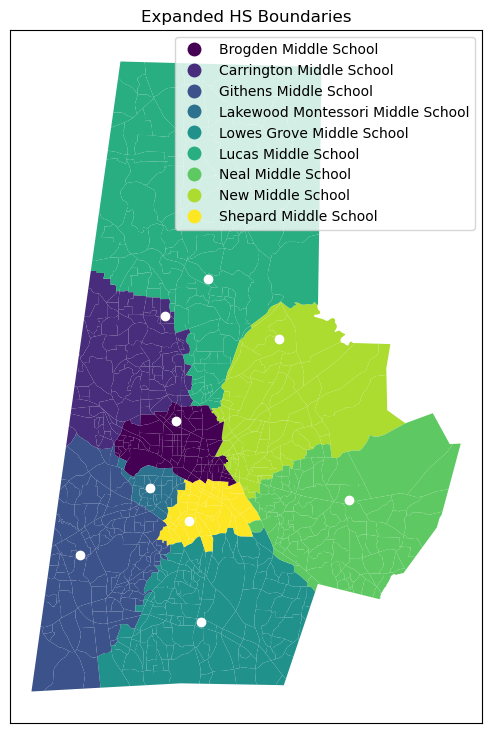

In [47]:
fig,ax = plt.subplots(figsize = (7,9))

local_ms_full_geo.plot(
    column='assign',
    ax = ax,
    cmap = 'viridis',
    legend = True
)

ax.set_xticks([])
ax.set_yticks([])

plt.title('Expanded HS Boundaries')
local_dps_base_ms.plot(ax=plt.gca(), color = 'white')

In [2]:
#boundary siting and scoring algorithm
def score_candidate(candidate,sgr,lower_bound,upper_bound):
    i=0
    counts = pd.DataFrame({'school':school_names,
                           'capacity':capacities,
                           'count':[0,0,0,0,0,0],
                           'adjust':[0,0,0,0,0,0]
                            })                              

    
    candidate_geom = candidate['geometry']
    local_dps_base_hs.loc[5,'geometry']=candidate_geom.centroid
    counts['pct_capacity'] = counts['count']/counts['capacity']
    
    
    while ((counts['pct_capacity']<lower_bound/100)|(counts['pct_capacity']>upper_bound/100)).any():                                    
        assignments = []
        for pu in local_hs_full_geo.itertuples(index=False):                   
            centroid = pu.geometry.centroid
            pu_scores = []
            for j in range(6):    
                dist = centroid.distance(local_dps_base_hs.loc[j,'geometry'])
                score = dist + counts.loc[j,'adjust']
                pu_scores.append(score)
            assign = school_names[pu_scores.index(min(pu_scores))]
            assignments.append(assign)
        local_hs_full_geo['assign'] = assignments
    
        for j,school in enumerate(school_names):
            assigned_students = int(local_hs_full_geo.loc[local_hs_full_geo['assign'] == school, 'basez'].sum() + local_hs_full_geo.loc[local_hs_full_geo['assign'] == school, 'student_gen'].sum()*sgr/100)
            counts.loc[j, 'count'] = assigned_students  
                
            if counts.loc[j,'count'] <= counts.loc[j,'capacity']*lower_bound/100:
                counts.loc[j,'adjust'] -= 200
            elif counts.loc[j,'count'] >= counts.loc[j,'capacity']*upper_bound/100:
                counts.loc[j,'adjust'] += 200
            else:
                pass
        counts['pct_capacity'] = counts['count']/counts['capacity']
        i+=1

    objective=local_hs_full_geo.merge(local_dps_base_hs,left_on='assign',right_on='name',how='left')
    objective['distance']=objective['geometry_x'].distance(objective['geometry_y'])
    objective_score = ((objective['basez']+sgr*objective['student_gen']/100)*objective['distance']).sum()/(10**7)


    return i,objective_score,counts
    
    #punish objective score if still over cap

In [4]:
candidate = dps_pu.loc[317]
score_candidate(candidate,30,80,120)

NameError: name 'dps_pu' is not defined

<Axes: title={'center': 'Expanded HS Boundaries'}>

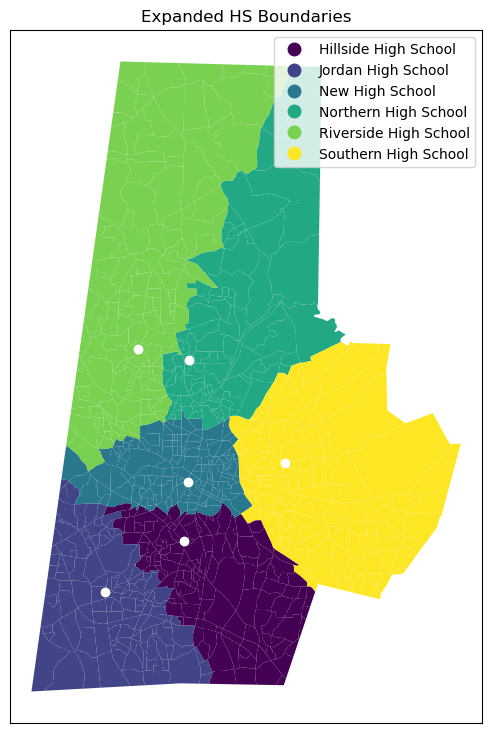

In [16]:
fig,ax = plt.subplots(figsize = (7,9))

local_hs_full_geo.plot(
    column='assign',
    ax = ax,
    cmap = 'viridis',
    legend = True
)

ax.set_xticks([])
ax.set_yticks([])

plt.title('Expanded HS Boundaries')
local_dps_base_hs.plot(ax=plt.gca(), color = 'white')